In [1]:
from datetime import datetime
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from torch.func import jacrev
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [2]:
class PolynomialRegression:
    
    def __init__(self, coef_lb, coef_ub, degree):
        self.coef_arr = np.random.uniform(coef_lb, coef_ub, degree + 1)

    def __call__(self, x):
        return np.sum([coef * x ** i for i, coef in enumerate(self.coef_arr)], axis=0)
    
def get_gaussian_data(d0, data_size, target_fn):
    x = np.random.normal(size=(data_size, d0))
    y = target_fn(x)
    return x, y

In [3]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
#         torch.nn.init.zeros_(lin_layer1.bias)
        torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))        
        torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
        torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
def get_A_and_rank(model, x):
    erin geo

def get_distance_to_boundary(model, x):
    np_weight = model.layers[0].weight.detach().numpy()
    np_bias = model.layers[0].bias.detach().numpy()
    np_x = x.detach().numpy()
    distance_arr = [np.min([np.abs((b + one_x[0] * w[0])) / np.linalg.norm([1, one_x[0]])
                            for w, b in zip(np_weight, np_bias)]) for one_x in np_x]    
    return distance_arr
                
# Relatively slow but certain
# Rewrite later if needed 
def get_jacobian_rank_spectrum(model, x):
    jacobian = []
    for one_x in x:
        model(one_x).backward()        
        grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
        jacobian.append(torch.cat(grads).numpy())
        
    jacobian = np.asarray(jacobian)
#     rank = np.linalg.matrix_rank(jacobian.astype(np.float64))
    
    spectrum = scipy.linalg.svdvals(jacobian)
    ratio = np.min(spectrum) / np.max(spectrum)
    
#     return rank, ratio
    return None, ratio

def train(model, optimizer, loss_fn, x, y, epochs_num, distance_epoch):
    start_time = datetime.now()
    
    loss_arr = []
    rank_arr = []
    ratio_arr = []
    a_rank_arr = []
    pattern_arr = []
    distance_arr = []
    
    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    loss_arr.append(loss.detach().numpy())
    
    rank, ratio = get_jacobian_rank_spectrum(model, x)
    rank_arr.append(rank)
    ratio_arr.append(ratio)
    
    pattern, a_rank = get_A_and_rank(model, x)
    pattern_arr.append(pattern)
    a_rank_arr.append(a_rank)
    
    distance_arr.append(get_distance_to_boundary(model, x))

    for e_id in range(epochs_num):
        model.train(True)
        
        # We use full-batch gradient descent
        optimizer.zero_grad()

        pred_y = model(x)
        loss = loss_fn(pred_y, y)
        
        loss.backward()
        optimizer.step()     

        print(f'Epoch {e_id + 1}. Loss: {loss.item()}')
        
        loss_arr.append(loss.detach().numpy())
        
        rank, ratio = get_jacobian_rank_spectrum(model, x)
        rank_arr.append(rank)
        ratio_arr.append(ratio)
        
        pattern, a_rank = get_A_and_rank(model, x)
        pattern_arr.append(pattern)
        a_rank_arr.append(a_rank)
    
        if (e_id + 1) % distance_epoch == 0:
            distance_arr.append(get_distance_to_boundary(model, x))
            
    total_time = datetime.now() - start_time
    hours = int(total_time.seconds / 3600)
    minutes = int(total_time.seconds / 60 - hours * 60)
    seconds = int(total_time.seconds - hours * 3600 - minutes * 60)
    print(f'Elapsed time: {hours}h {minutes}min {int(seconds)}s')
        
    return loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr

# Step 1. Train the network

Epoch 1. Loss: 4.994585037231445
Epoch 2. Loss: 2.6198558807373047
Epoch 3. Loss: 1.4857875108718872
Epoch 4. Loss: 0.6509318351745605
Epoch 5. Loss: 0.36224764585494995
Epoch 6. Loss: 0.6360137462615967
Epoch 7. Loss: 0.9044387936592102
Epoch 8. Loss: 0.9058360457420349
Epoch 9. Loss: 0.8564714789390564
Epoch 10. Loss: 0.823752760887146
Epoch 11. Loss: 0.6840043663978577
Epoch 12. Loss: 0.4374305307865143
Epoch 13. Loss: 0.22678042948246002
Epoch 14. Loss: 0.14409826695919037
Epoch 15. Loss: 0.14069224894046783
Epoch 16. Loss: 0.1407012790441513
Epoch 17. Loss: 0.15394702553749084
Epoch 18. Loss: 0.2111707627773285
Epoch 19. Loss: 0.27445361018180847
Epoch 20. Loss: 0.28045544028282166
Epoch 21. Loss: 0.2306743562221527
Epoch 22. Loss: 0.17525045573711395
Epoch 23. Loss: 0.13712787628173828
Epoch 24. Loss: 0.09900535643100739
Epoch 25. Loss: 0.05688149109482765
Epoch 26. Loss: 0.03583843633532524
Epoch 27. Loss: 0.05011134222149849
Epoch 28. Loss: 0.07748076319694519
Epoch 29. Loss: 0

Epoch 221. Loss: 0.002460532821714878
Epoch 222. Loss: 0.0024431224446743727
Epoch 223. Loss: 0.0024258445482701063
Epoch 224. Loss: 0.00240869983099401
Epoch 225. Loss: 0.0023916768841445446
Epoch 226. Loss: 0.0023747875820845366
Epoch 227. Loss: 0.002358023775741458
Epoch 228. Loss: 0.0023413912858814
Epoch 229. Loss: 0.002324884757399559
Epoch 230. Loss: 0.0023084920831024647
Epoch 231. Loss: 0.002292273100465536
Epoch 232. Loss: 0.0022761716973036528
Epoch 233. Loss: 0.0022601804230362177
Epoch 234. Loss: 0.002244324889034033
Epoch 235. Loss: 0.0022285867016762495
Epoch 236. Loss: 0.002212974475696683
Epoch 237. Loss: 0.0021974854171276093
Epoch 238. Loss: 0.0021821078844368458
Epoch 239. Loss: 0.0021668393164873123
Epoch 240. Loss: 0.0021516771521419287
Epoch 241. Loss: 0.0021366560831665993
Epoch 242. Loss: 0.002121729776263237
Epoch 243. Loss: 0.00210689683444798
Epoch 244. Loss: 0.0020921670366078615
Epoch 245. Loss: 0.002077548997476697
Epoch 246. Loss: 0.002063040155917406
Ep

Epoch 433. Loss: 0.0006328584859147668
Epoch 434. Loss: 0.0006295763887465
Epoch 435. Loss: 0.0006263309624046087
Epoch 436. Loss: 0.0006230947910808027
Epoch 437. Loss: 0.0006198821356520057
Epoch 438. Loss: 0.000616694800555706
Epoch 439. Loss: 0.0006135325529612601
Epoch 440. Loss: 0.000610393937677145
Epoch 441. Loss: 0.0006072779069654644
Epoch 442. Loss: 0.0006041862070560455
Epoch 443. Loss: 0.0006011163932271302
Epoch 444. Loss: 0.0005980729474686086
Epoch 445. Loss: 0.000595058489125222
Epoch 446. Loss: 0.0005920612602494657
Epoch 447. Loss: 0.0005890921456739306
Epoch 448. Loss: 0.0005861425888724625
Epoch 449. Loss: 0.0005832212627865374
Epoch 450. Loss: 0.0005803140811622143
Epoch 451. Loss: 0.000577425817027688
Epoch 452. Loss: 0.0005745586822740734
Epoch 453. Loss: 0.0005717165186069906
Epoch 454. Loss: 0.0005688952514901757
Epoch 455. Loss: 0.0005660969181917608
Epoch 456. Loss: 0.000563321344088763
Epoch 457. Loss: 0.0005605608457699418
Epoch 458. Loss: 0.00055782857816

Epoch 643. Loss: 0.000254204060183838
Epoch 644. Loss: 0.000253223639447242
Epoch 645. Loss: 0.0002522413560654968
Epoch 646. Loss: 0.0002512559003662318
Epoch 647. Loss: 0.0002502683491911739
Epoch 648. Loss: 0.00024928461061790586
Epoch 649. Loss: 0.00024829976609908044
Epoch 650. Loss: 0.00024731692974455655
Epoch 651. Loss: 0.0002463333075866103
Epoch 652. Loss: 0.00024535463307984173
Epoch 653. Loss: 0.0002443761331960559
Epoch 654. Loss: 0.00024340194067917764
Epoch 655. Loss: 0.0002424302656436339
Epoch 656. Loss: 0.00024146195210050792
Epoch 657. Loss: 0.00024049683997873217
Epoch 658. Loss: 0.0002395360206719488
Epoch 659. Loss: 0.0002385794505244121
Epoch 660. Loss: 0.00023763066565152258
Epoch 661. Loss: 0.00023668678477406502
Epoch 662. Loss: 0.00023574473743792623
Epoch 663. Loss: 0.00023480610980186611
Epoch 664. Loss: 0.00023389520356431603
Epoch 665. Loss: 0.0002330149000044912
Epoch 666. Loss: 0.00023214274551719427
Epoch 667. Loss: 0.0002312781143700704
Epoch 668. Los

Epoch 850. Loss: 0.00013146518904250115
Epoch 851. Loss: 0.0001310915540670976
Epoch 852. Loss: 0.00013071969442535192
Epoch 853. Loss: 0.00013034886796958745
Epoch 854. Loss: 0.00012998045713175088
Epoch 855. Loss: 0.00012961376341991127
Epoch 856. Loss: 0.00012924475595355034
Epoch 857. Loss: 0.00012888031778857112
Epoch 858. Loss: 0.00012851791689172387
Epoch 859. Loss: 0.00012815477384719998
Epoch 860. Loss: 0.00012779366807080805
Epoch 861. Loss: 0.00012743425031658262
Epoch 862. Loss: 0.00012707778660114855
Epoch 863. Loss: 0.00012671925651375204
Epoch 864. Loss: 0.00012636477185878903
Epoch 865. Loss: 0.00012600957415997982
Epoch 866. Loss: 0.00012565623910631984
Epoch 867. Loss: 0.00012530418462119997
Epoch 868. Loss: 0.00012495294504333287
Epoch 869. Loss: 0.00012460449943318963
Epoch 870. Loss: 0.00012425683962646872
Epoch 871. Loss: 0.000123910722322762
Epoch 872. Loss: 0.0001235643430845812
Epoch 873. Loss: 0.00012322030670475215
Epoch 874. Loss: 0.000122877856483683
Epoch 

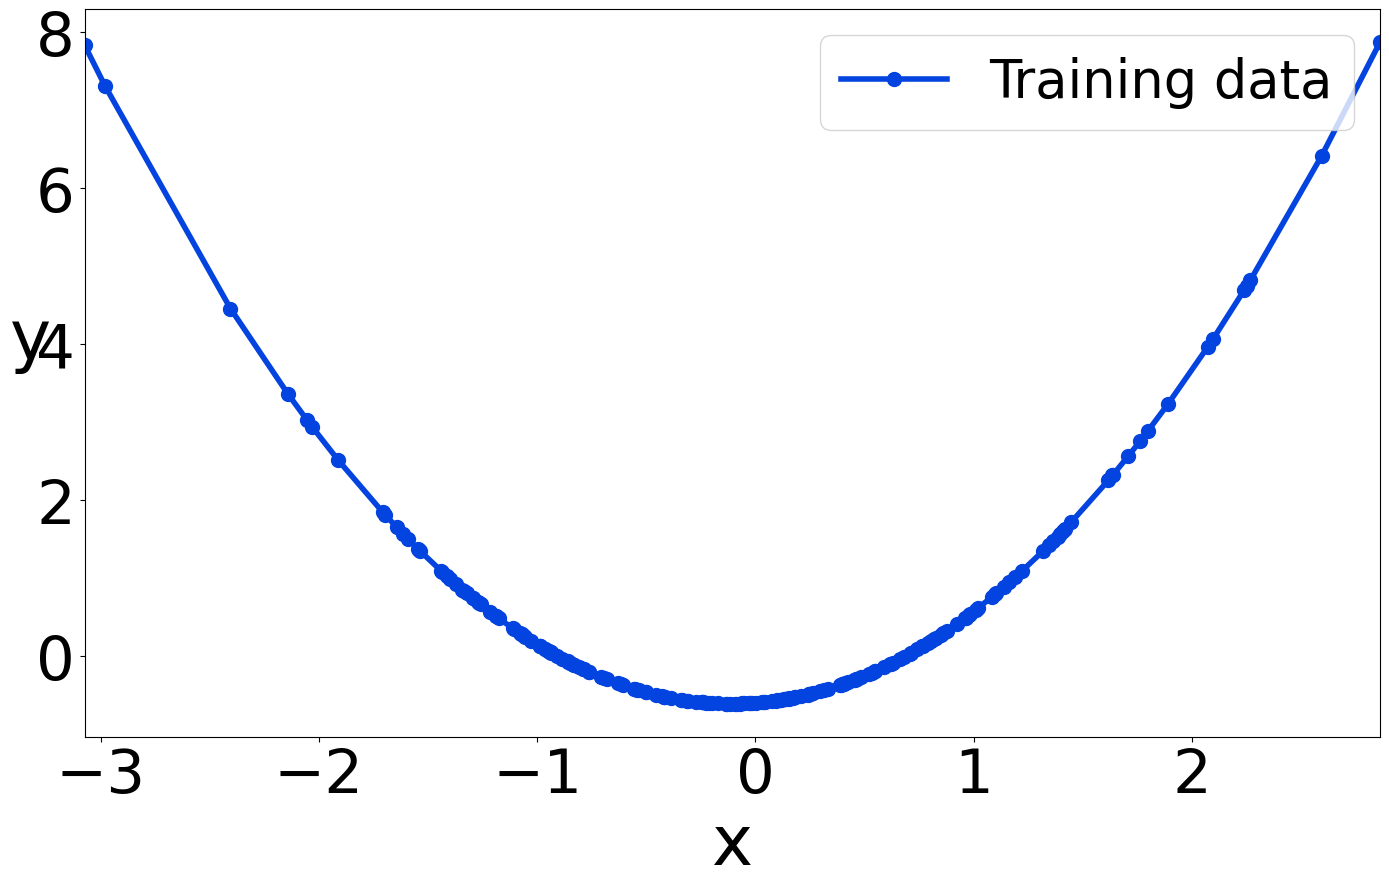

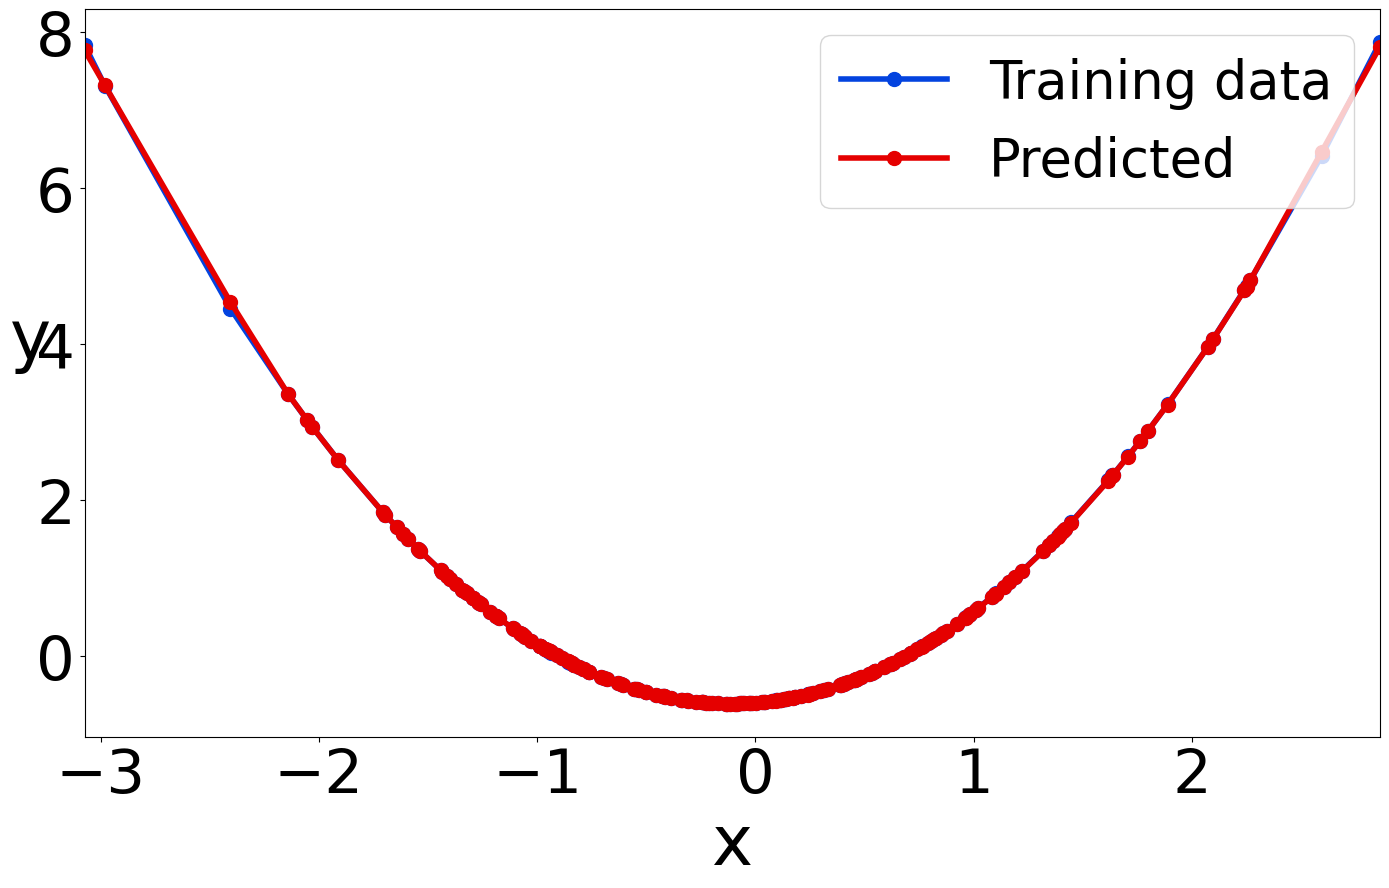

In [4]:
D1 = 800
DATA_SIZE = 200
DEGREE = 2
DISTANCE_EPOCH = 100
EPOCHS_NUM = 1000
LR = .1
RUNS_NUM = 1

#######################################################################################################
#######################################################################################################
def plot(x, y, pred_y=None):
    fig = plt.figure(figsize=(14, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    arr_ids = x.argsort(axis=0)
    sorted_x = np.take_along_axis(x, arr_ids, axis=0)
    sorted_y = np.take_along_axis(y, arr_ids, axis=0)
    plt.plot(sorted_x, sorted_y, linewidth=4, color='xkcd:blue', marker='o', markersize=10,
             label='Training data')
    
    if pred_y is not None:
        sorted_pred_y = np.take_along_axis(pred_y, arr_ids, axis=0)
        plt.plot(sorted_x, sorted_pred_y, linewidth=4, color='xkcd:red', marker='o', markersize=10,
                 label='Predicted')
        
    plt.ylabel('y', size=50, rotation=0)
    plt.xlabel('x', size=50)
    plt.xlim(xmin=min(x), xmax=max(x))

    plt.legend(loc='upper right', fontsize=38, title_fontsize=42)

    plt.tight_layout()
#     plt.savefig(f'images/gradients_during_training/fc_mnist_quartiles.png')
#######################################################################################################
#######################################################################################################

# Generate data
gen_x, gen_y = get_gaussian_data(d0=1, data_size=DATA_SIZE,
                         target_fn=PolynomialRegression(coef_lb=-1., coef_ub=1., degree=DEGREE))
plot(gen_x, gen_y)
x = torch.tensor(gen_x, dtype=torch.float)
y = torch.tensor(gen_y, dtype=torch.float)

total_loss = []
total_ranks = []
total_a_ranks = []
total_distances = []
total_ratios = []

for run_id in range(RUNS_NUM):
    model = TwoLayerNet(d0=1, d1=D1, d2=1)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     optimizer = torch.optim.SGD(model.parameters(), lr=LR)

    loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr = train(
        model=model, 
        optimizer=optimizer, 
        loss_fn=loss_fn, 
        x=x, 
        y=y, 
        epochs_num=EPOCHS_NUM,
        distance_epoch=DISTANCE_EPOCH
    )

#     print(f'rank_arr: {rank_arr}')
#     print(f'a_rank_arr: {a_rank_arr}')
#     print(f'ratio_arr: {ratio_arr}')
    total_loss.append(loss_arr)
    total_ranks.append(rank_arr)
    total_a_ranks.append(a_rank_arr)
    total_ratios.append(ratio_arr)
    total_distances.append(distance_arr)

# Plot the trained model predictions
model.train(False)
pred_y = model(x)
plot(gen_x, gen_y, pred_y.detach().numpy())

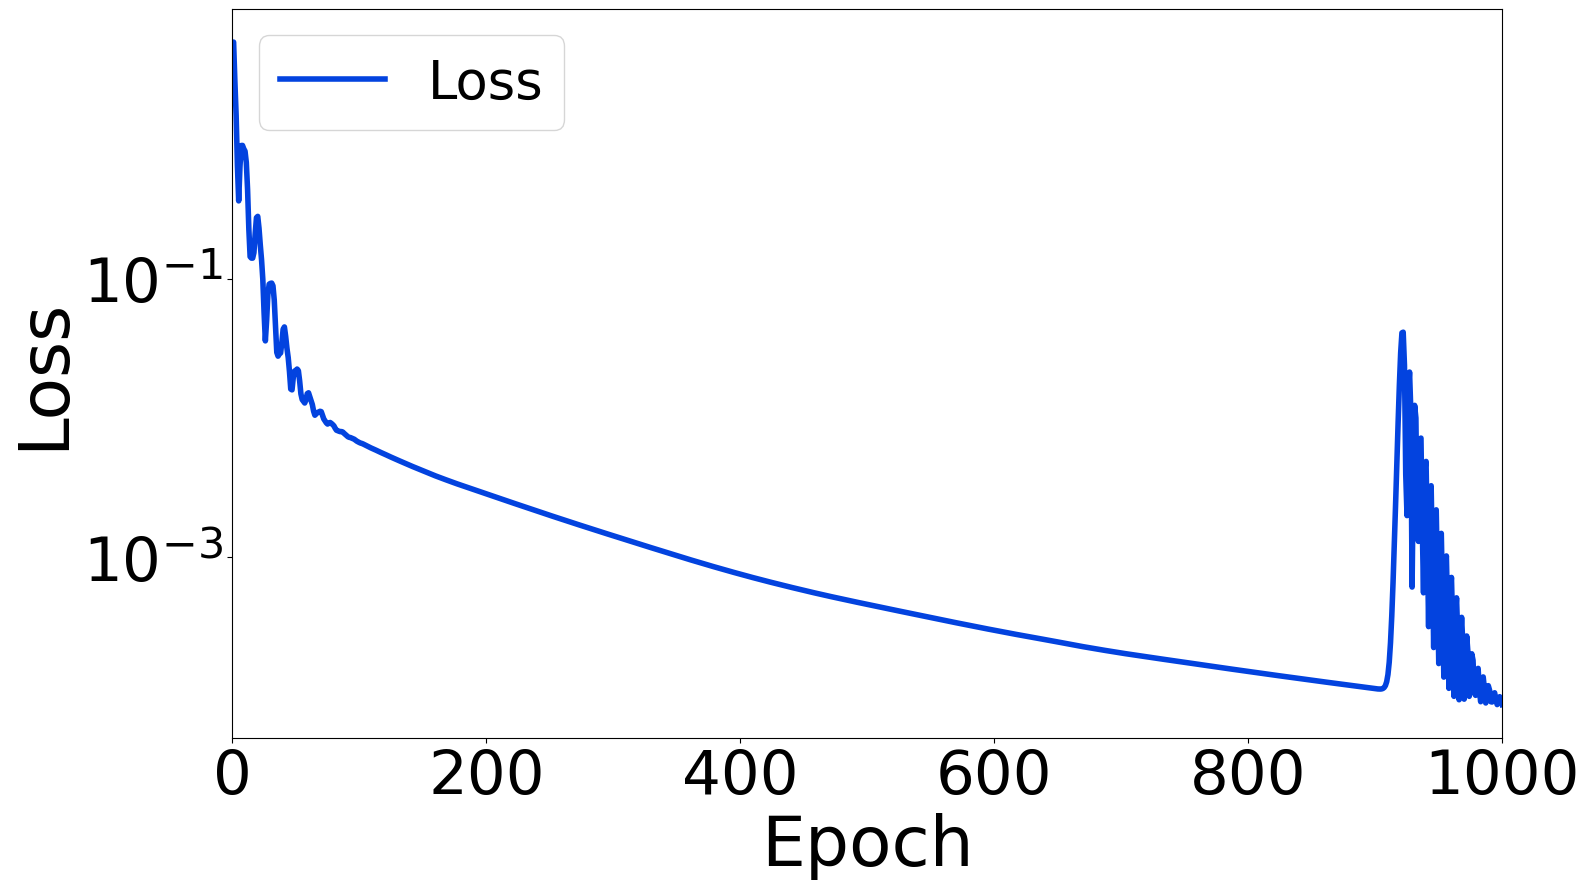

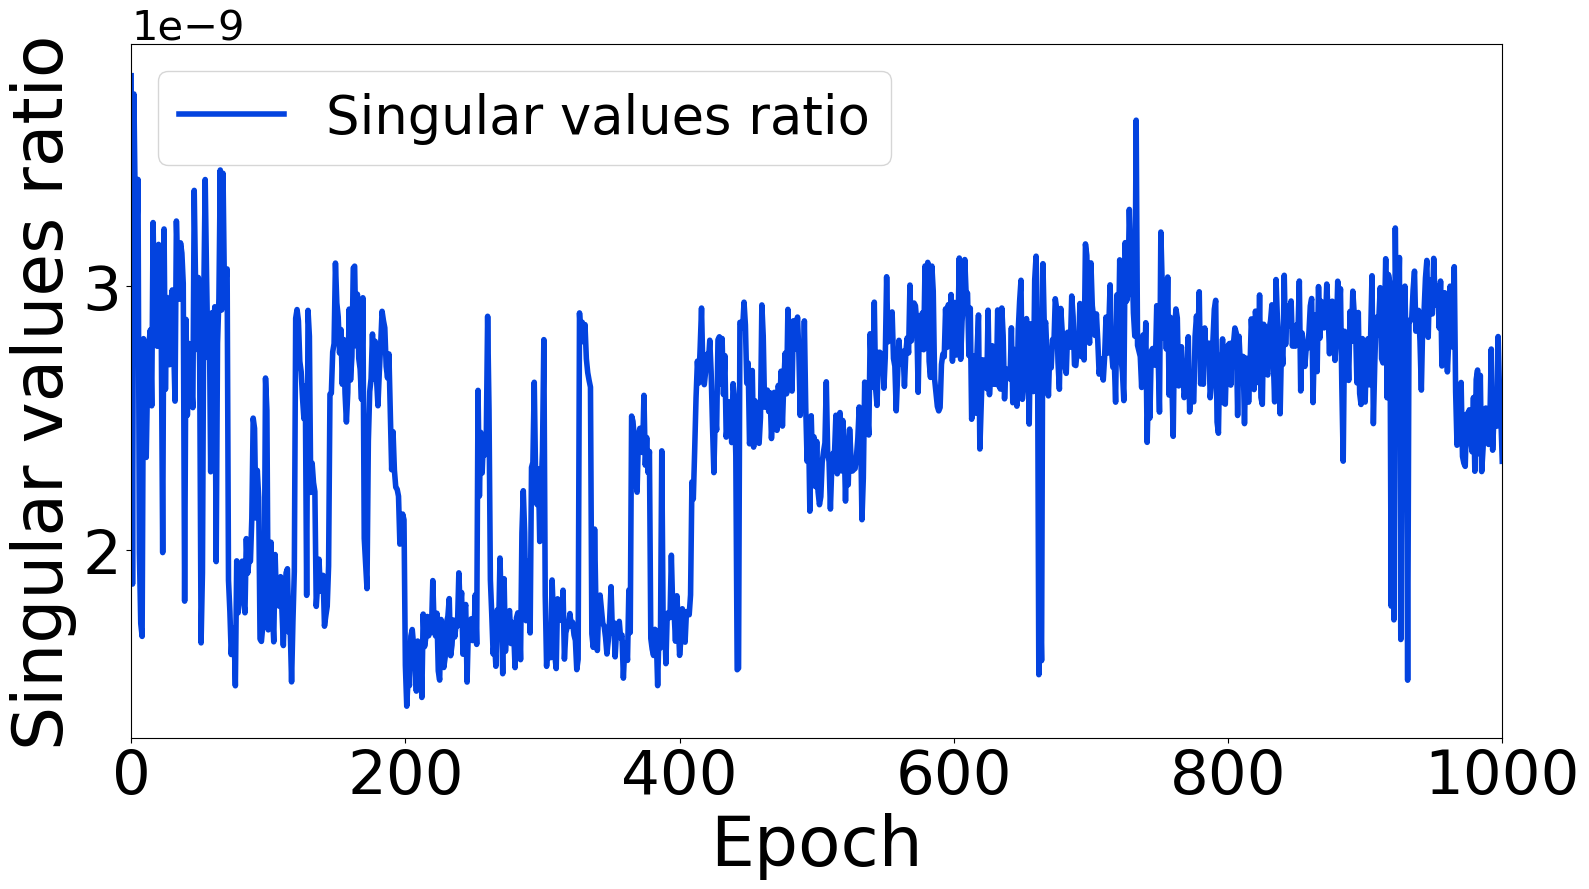

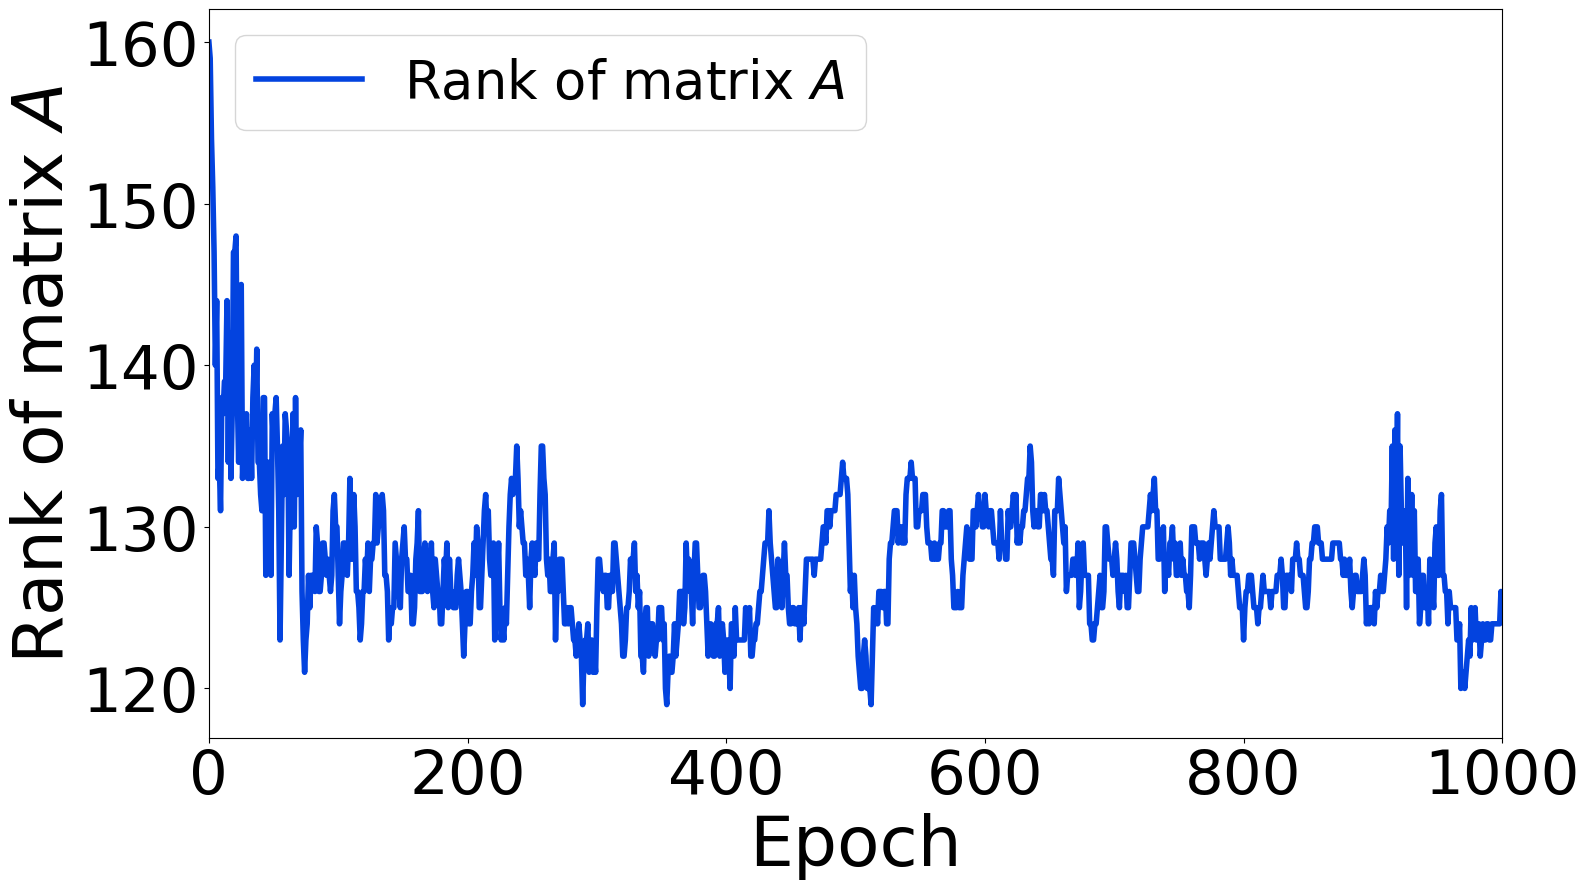

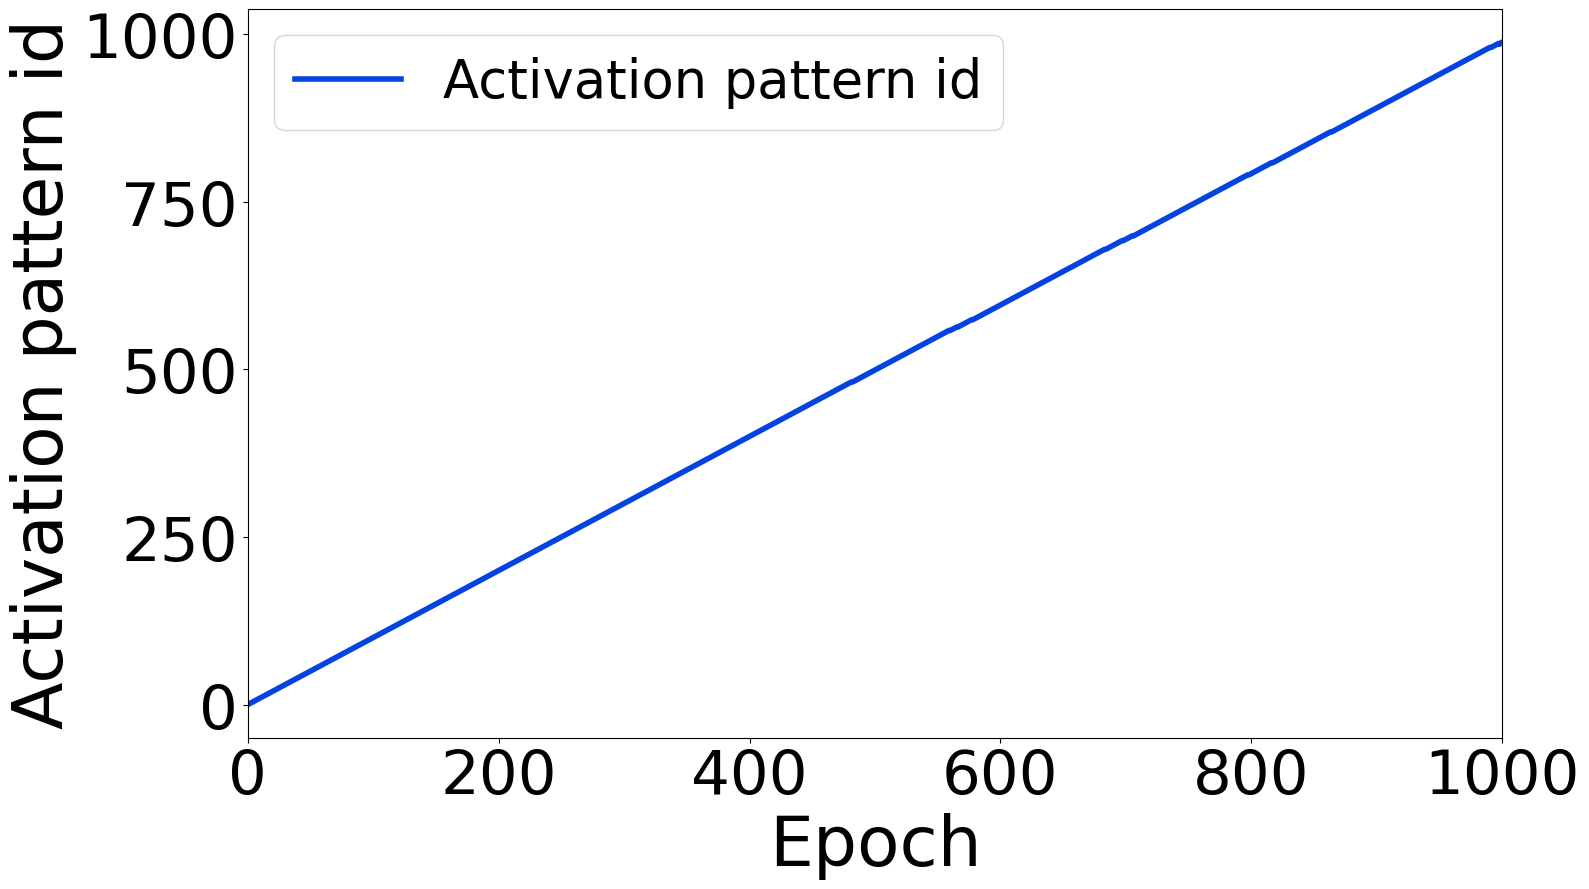

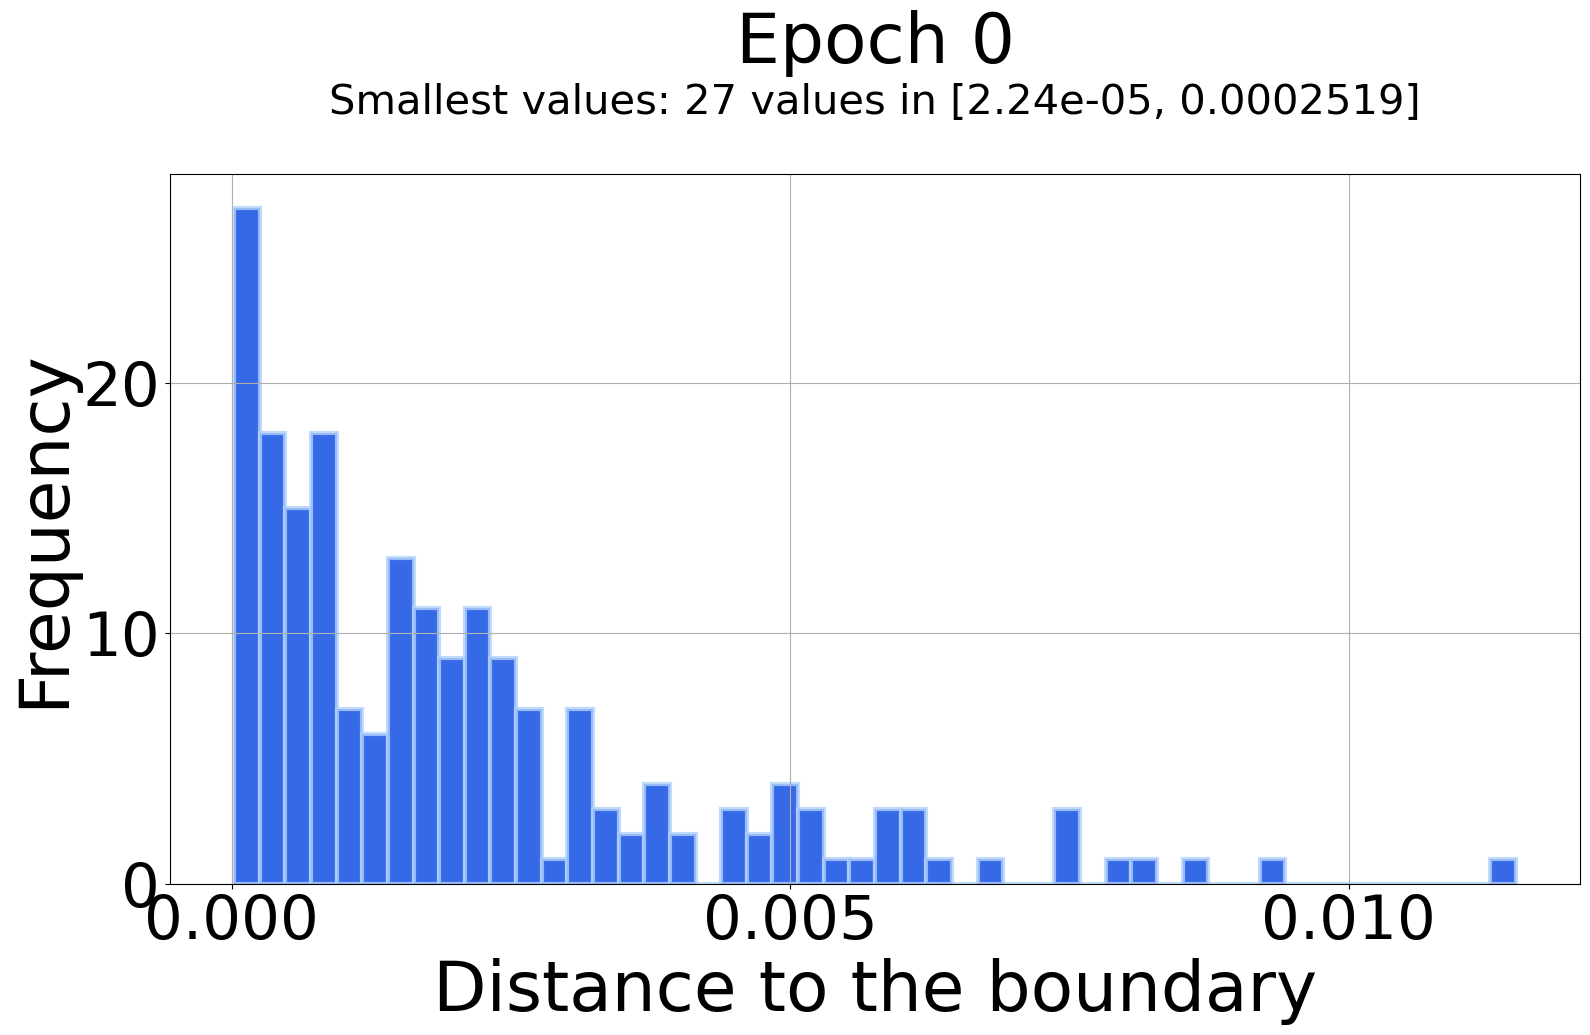

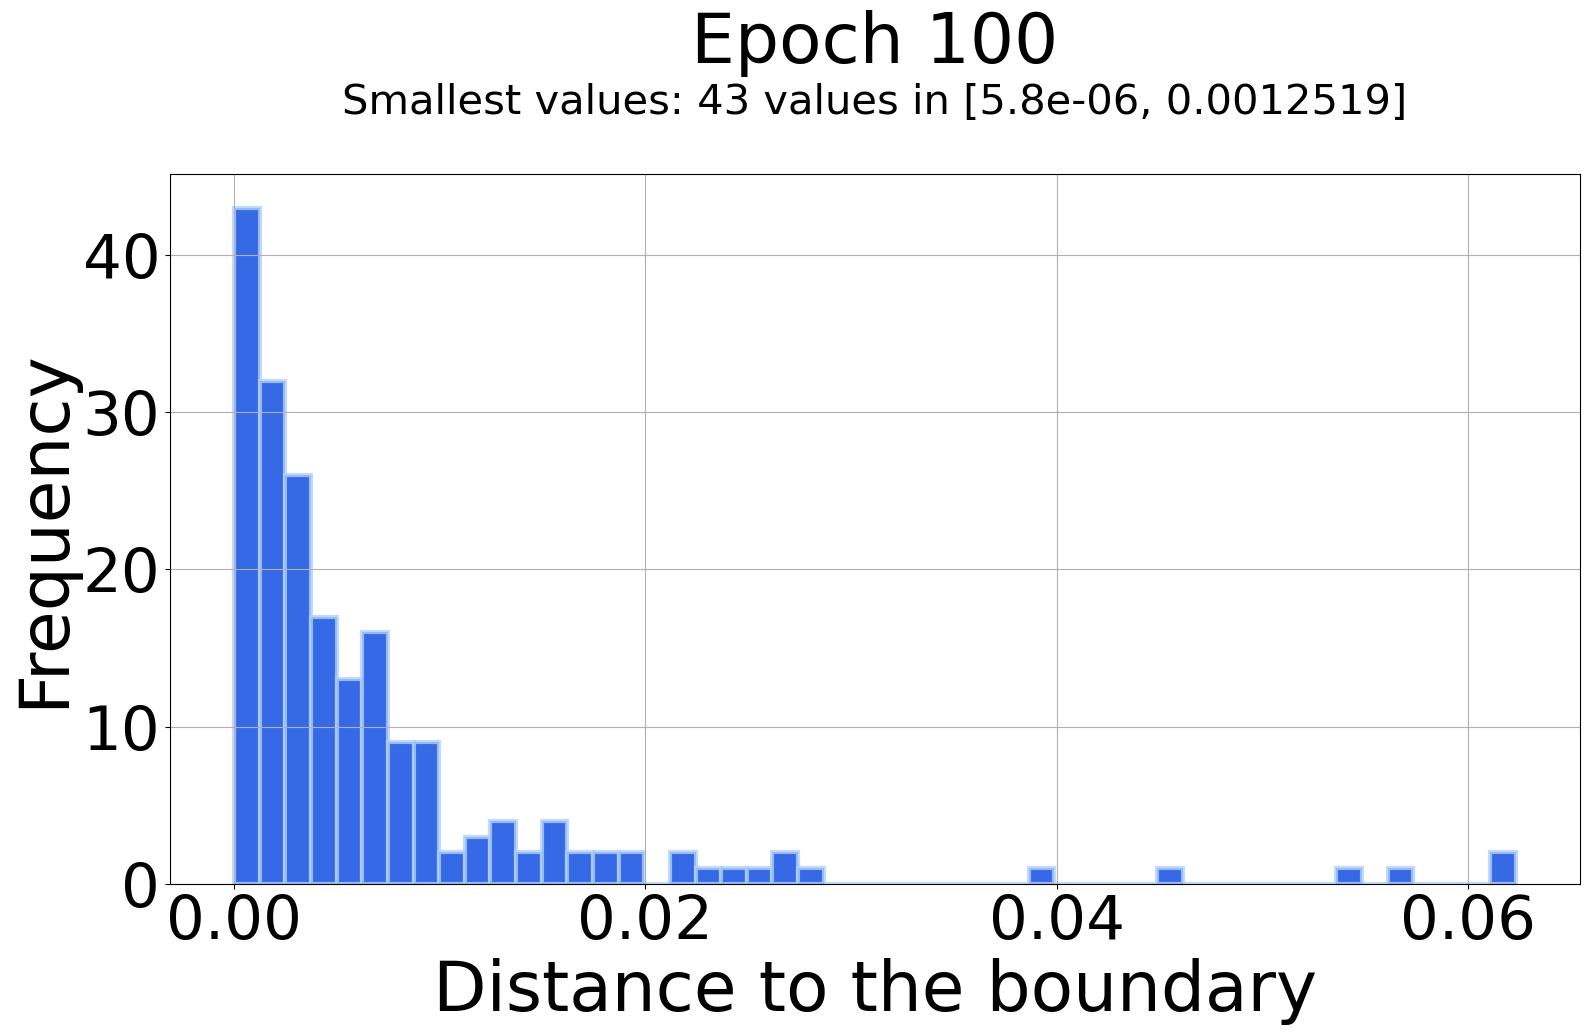

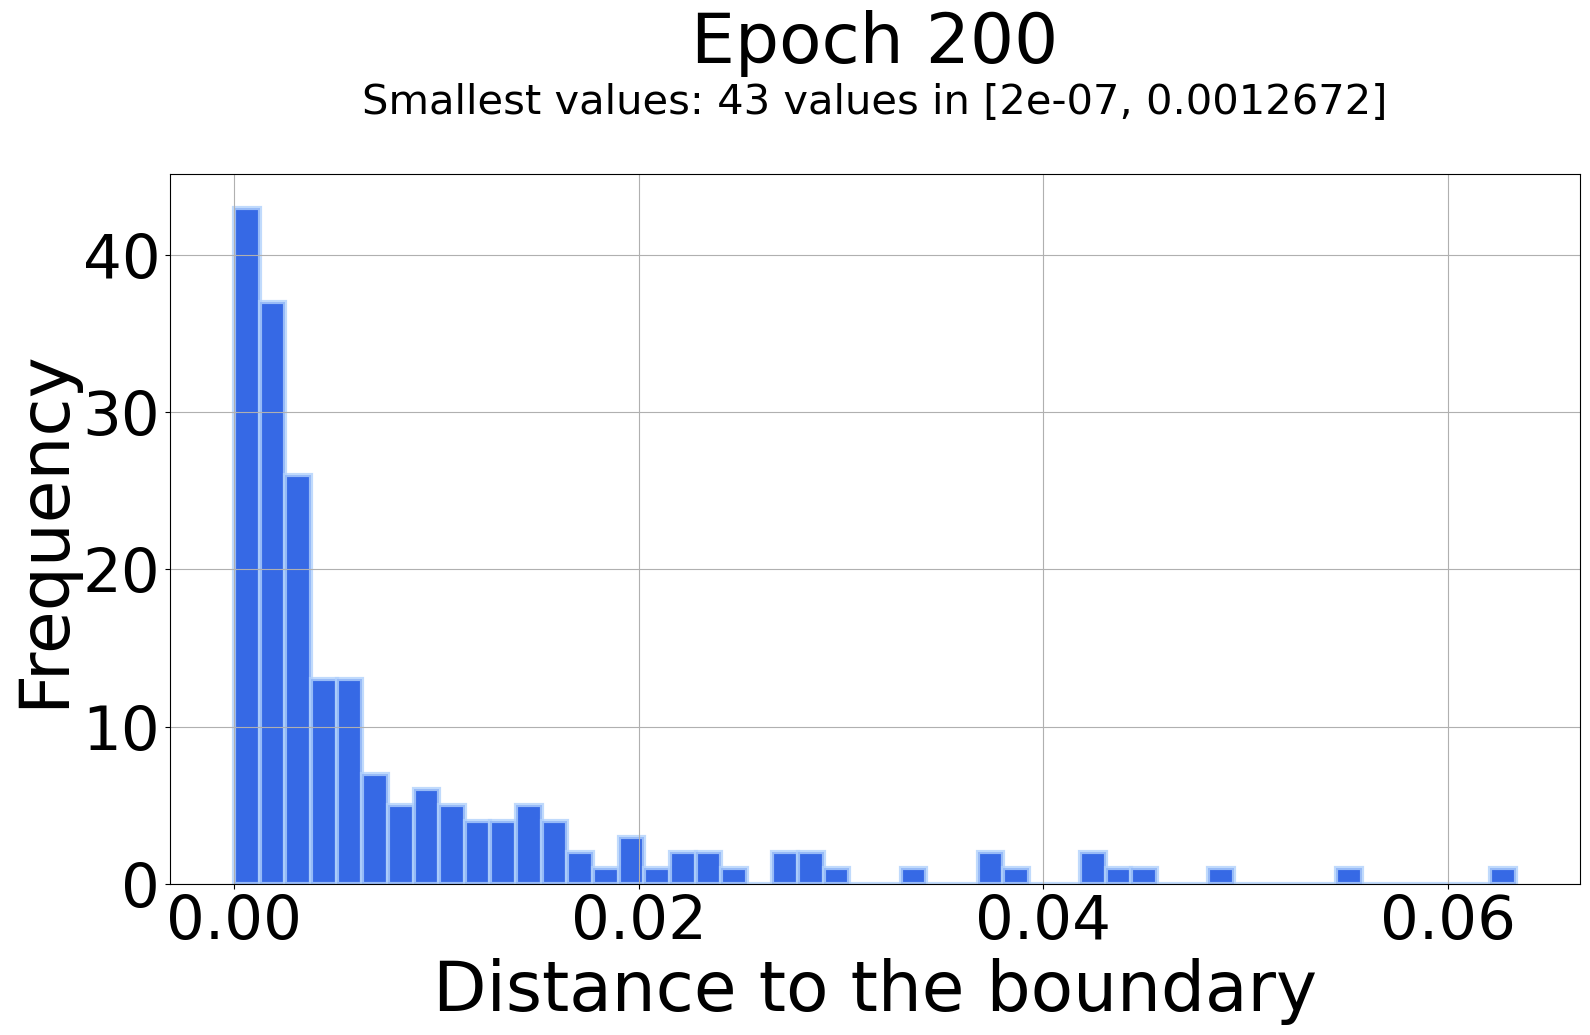

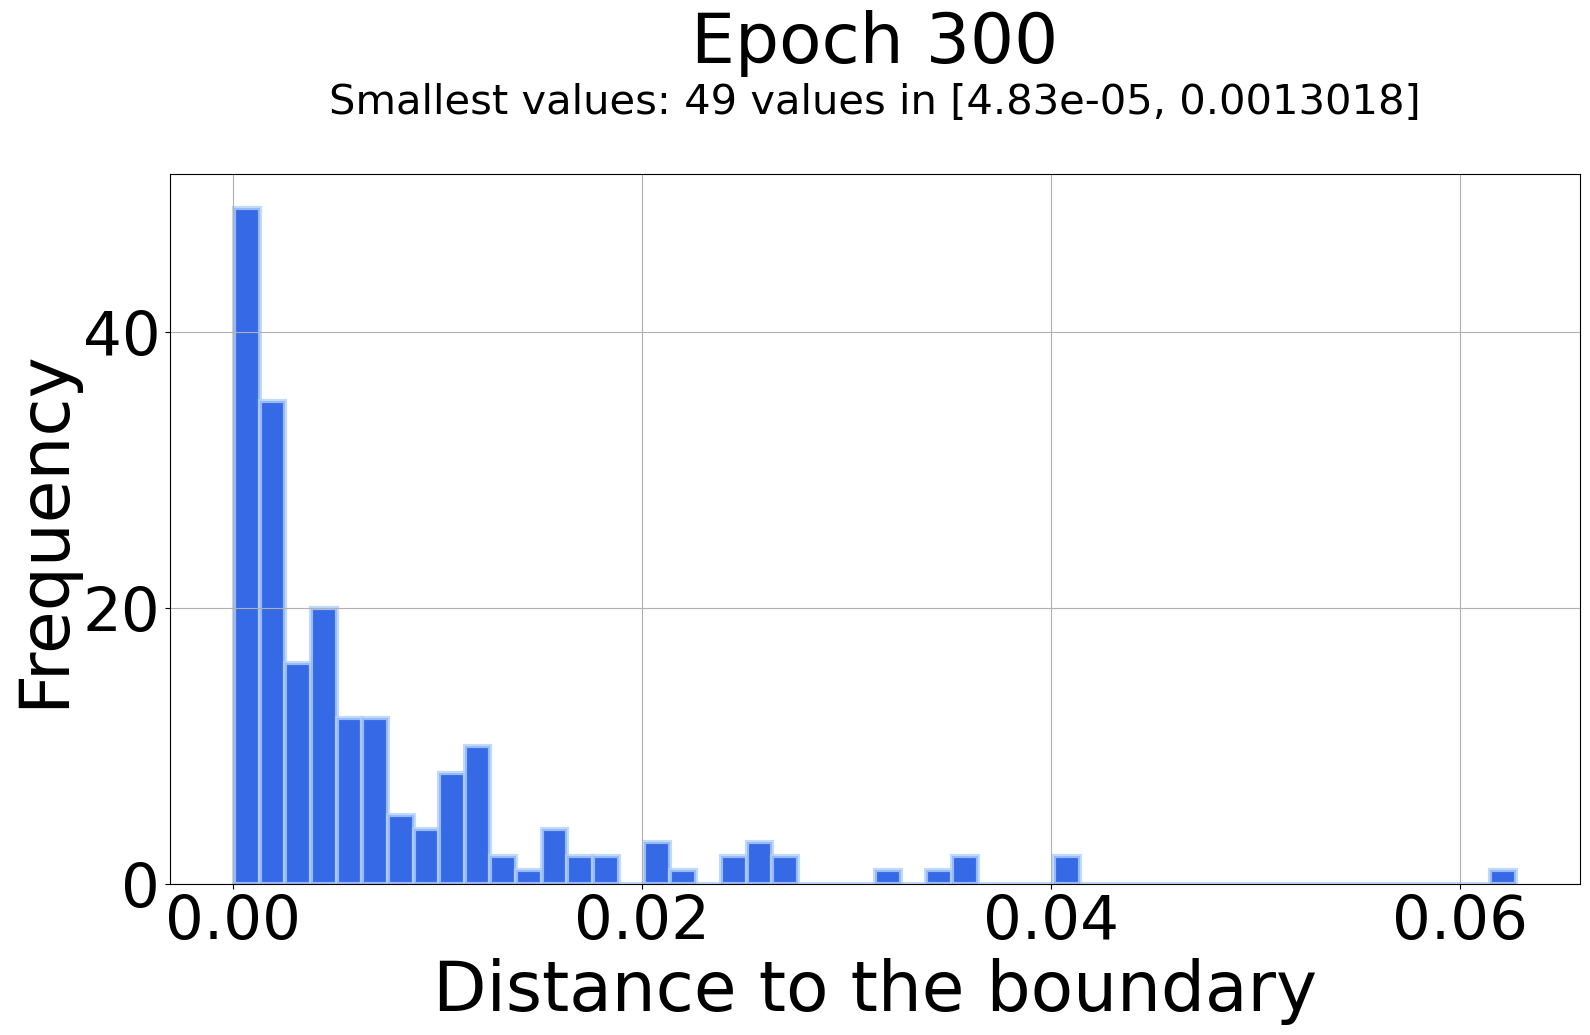

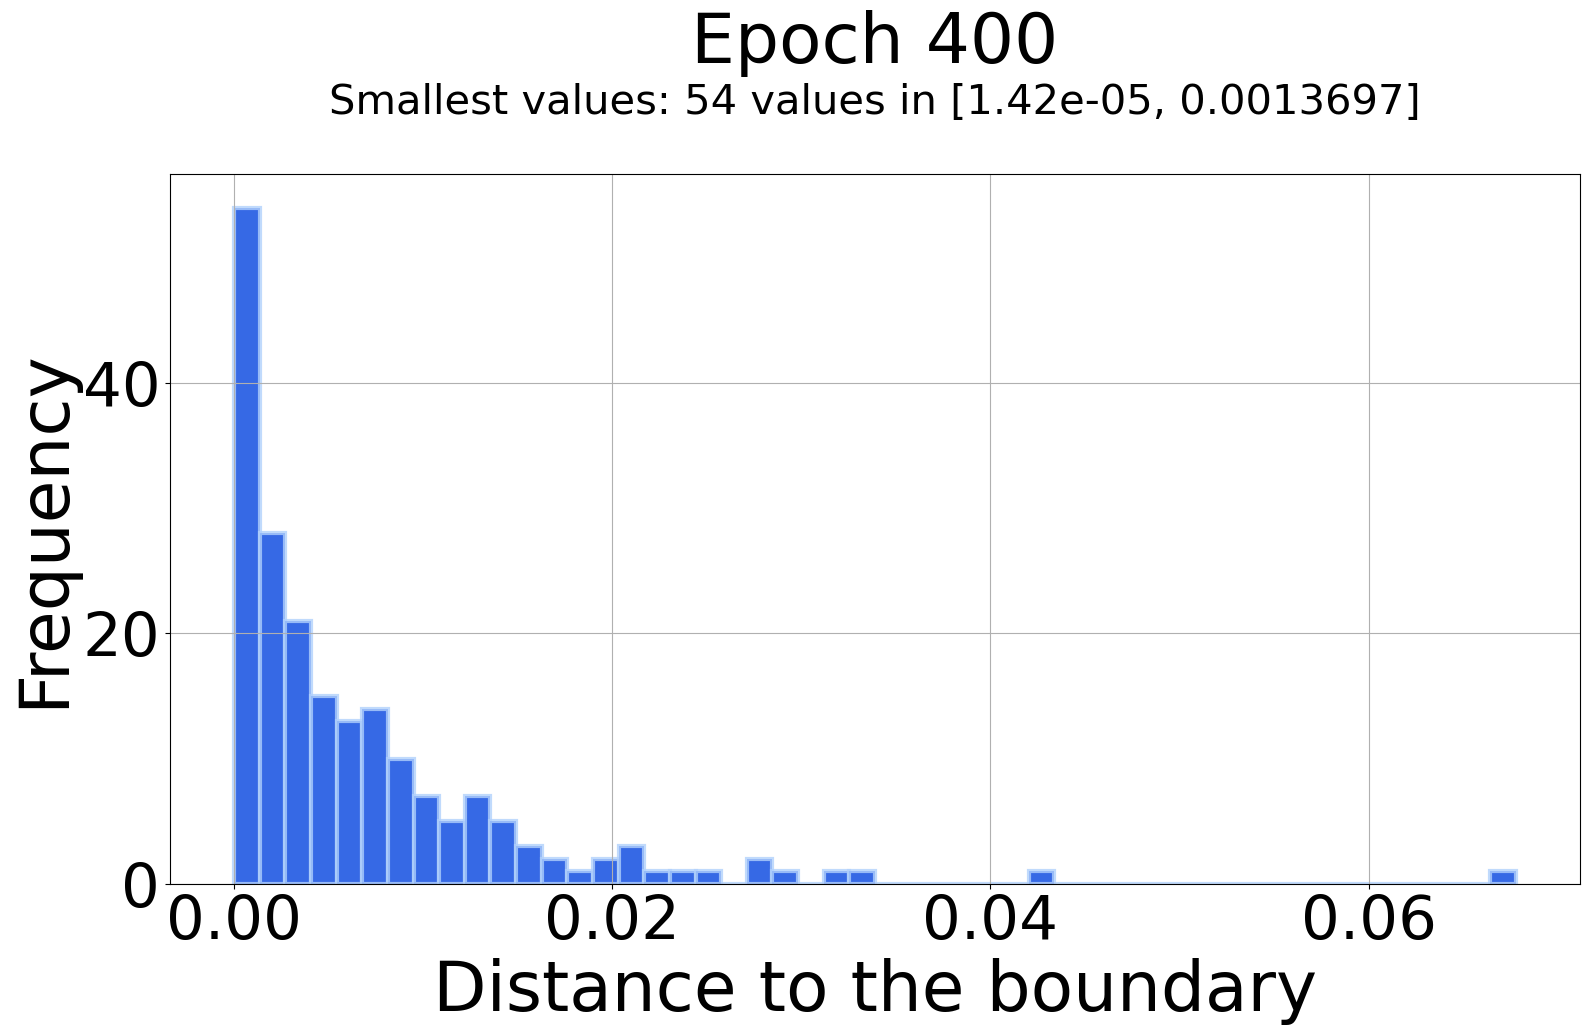

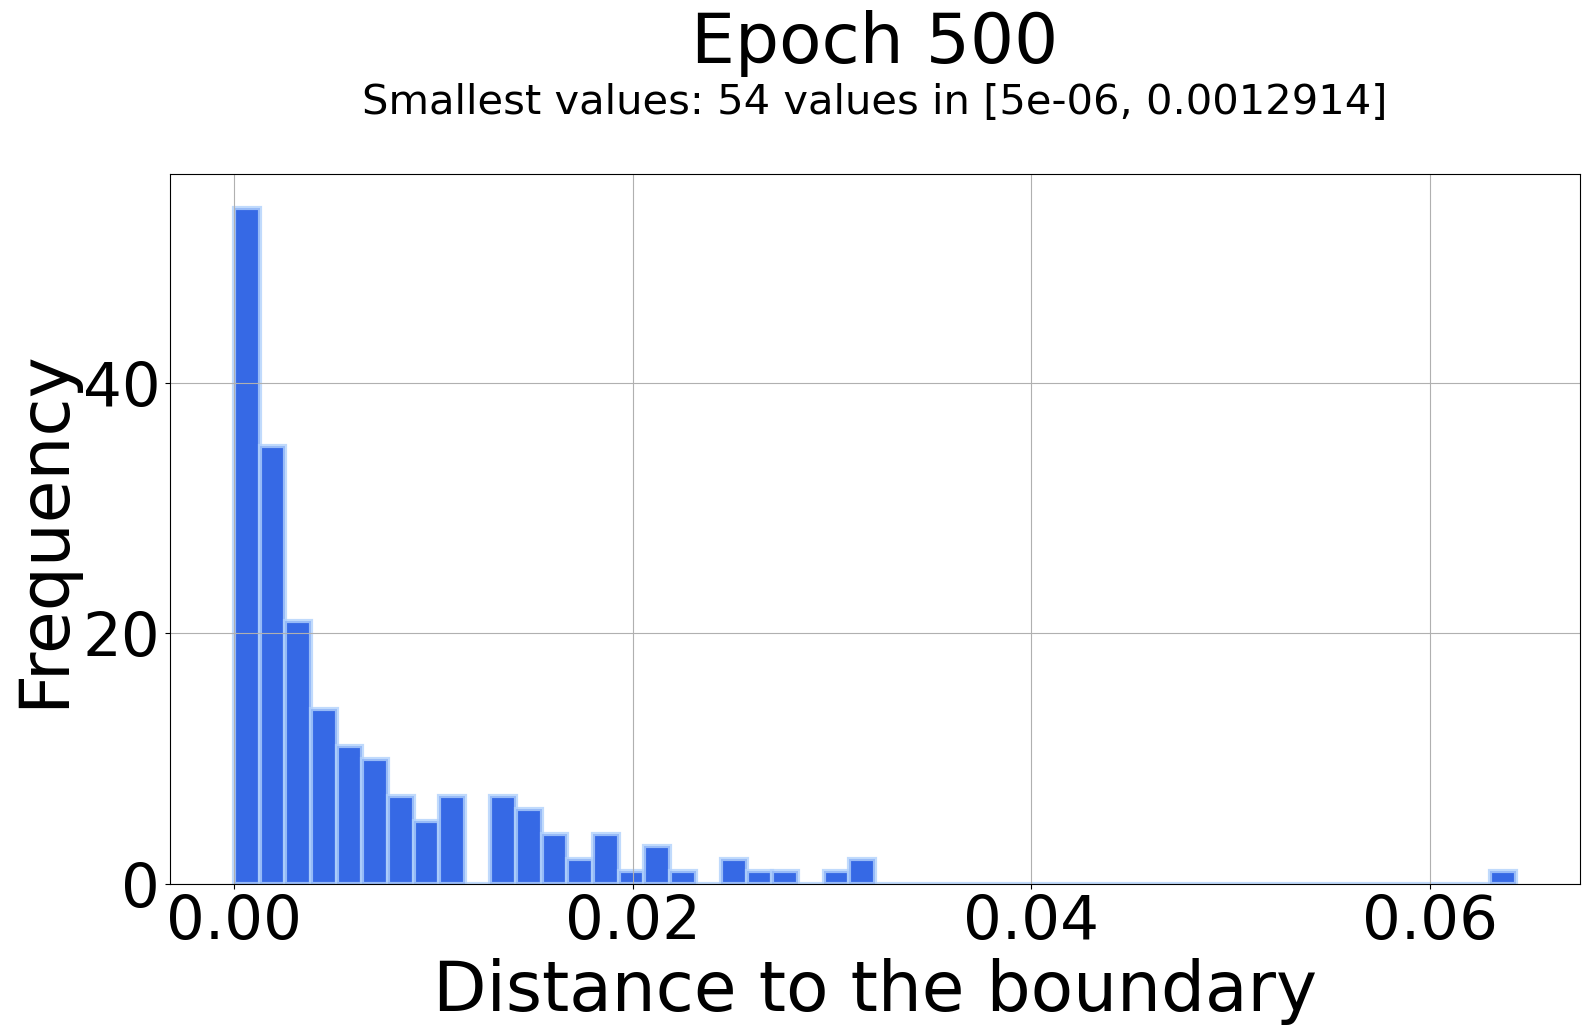

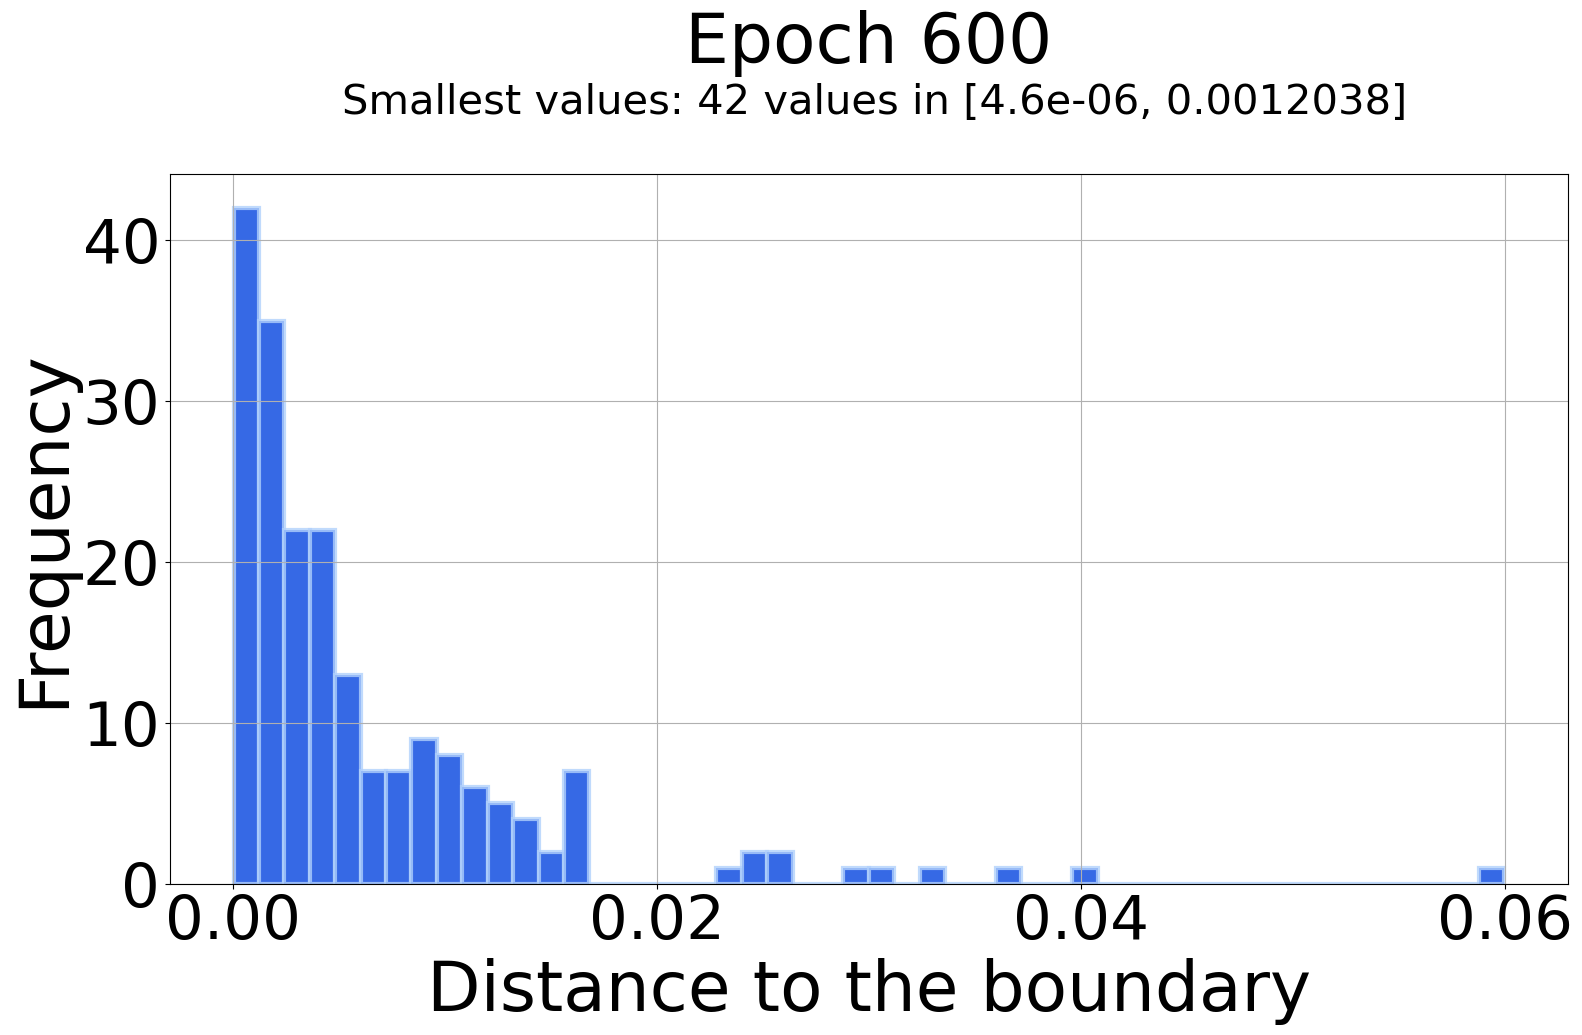

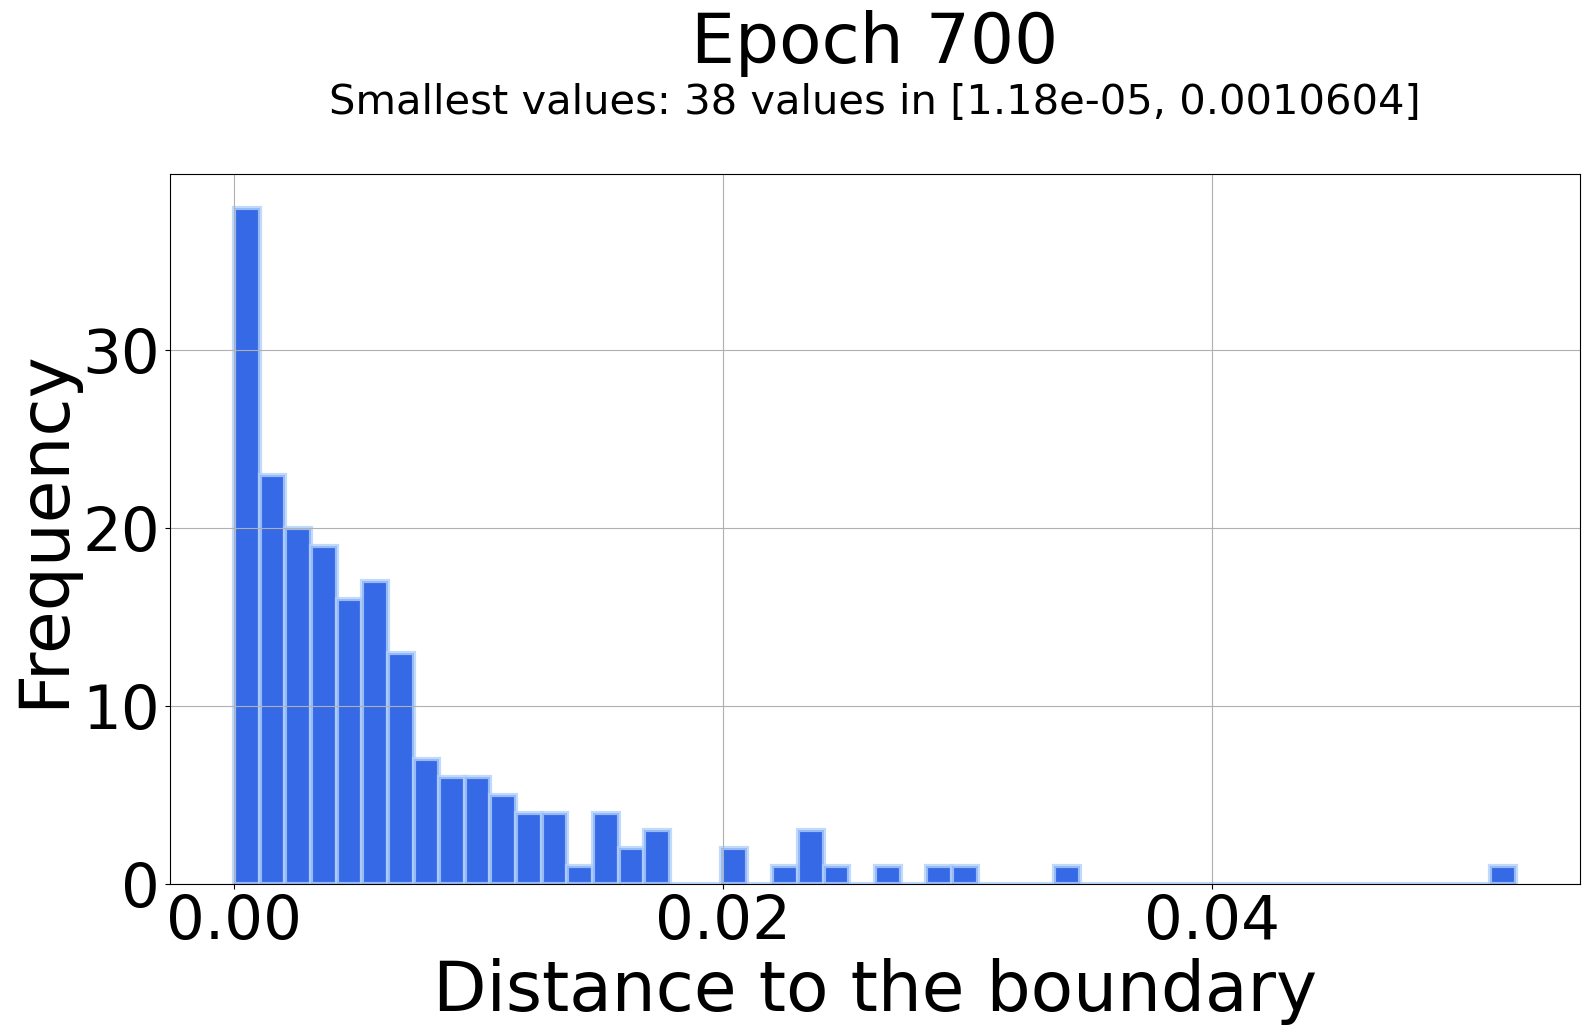

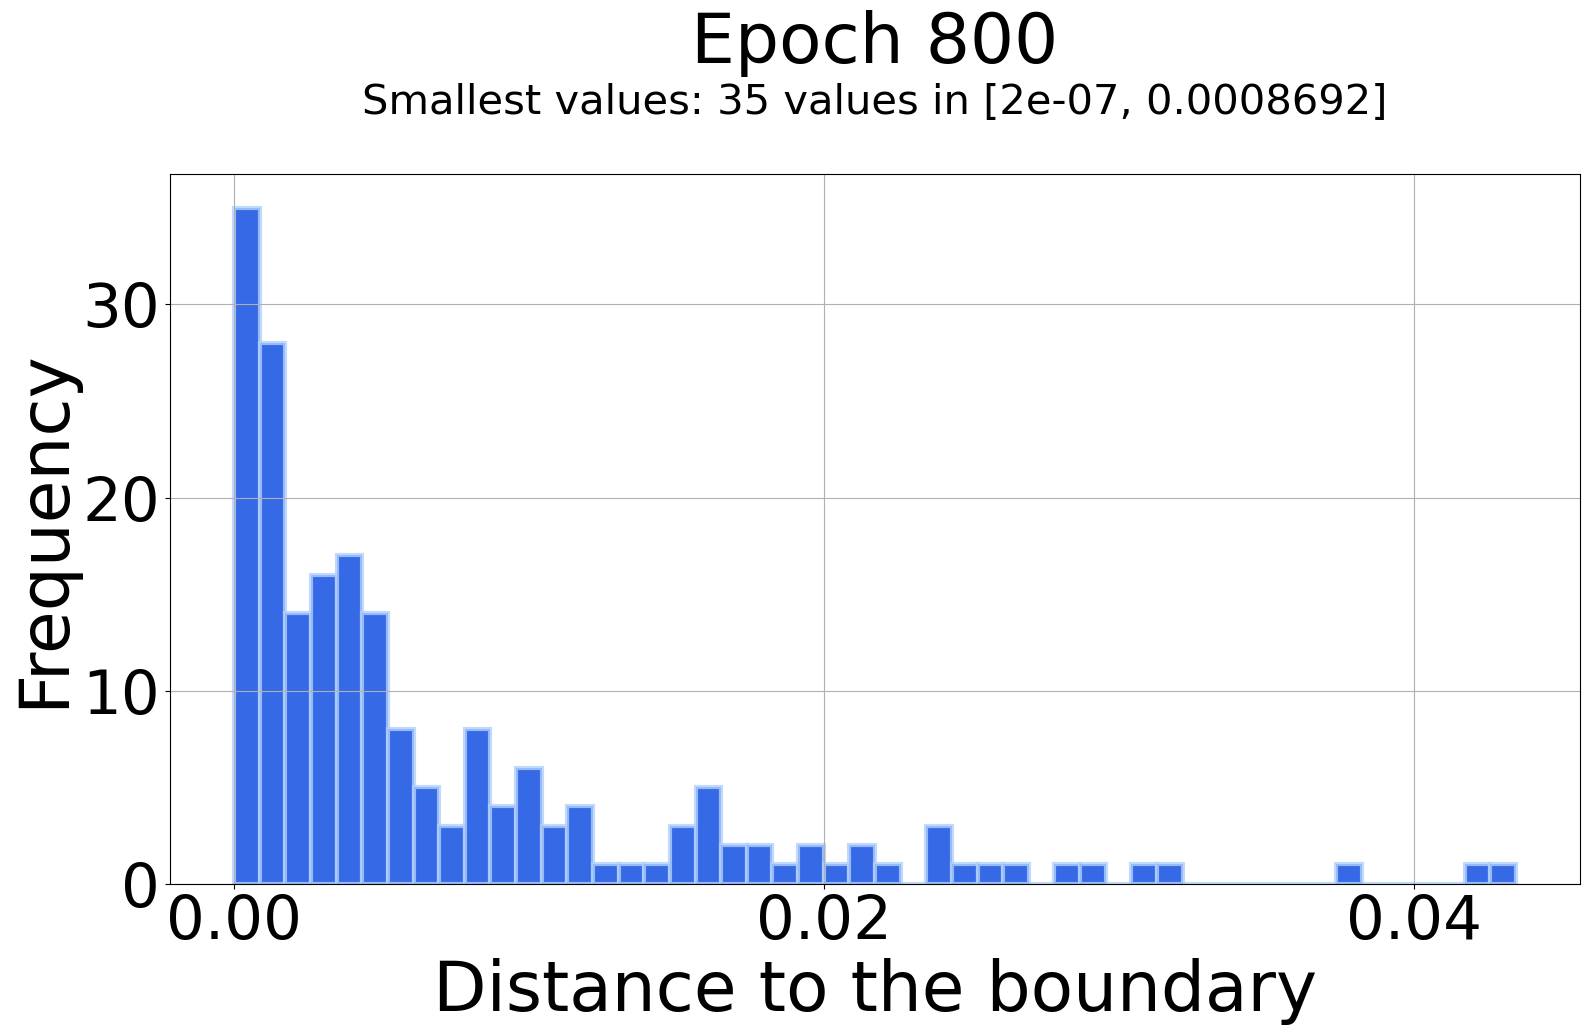

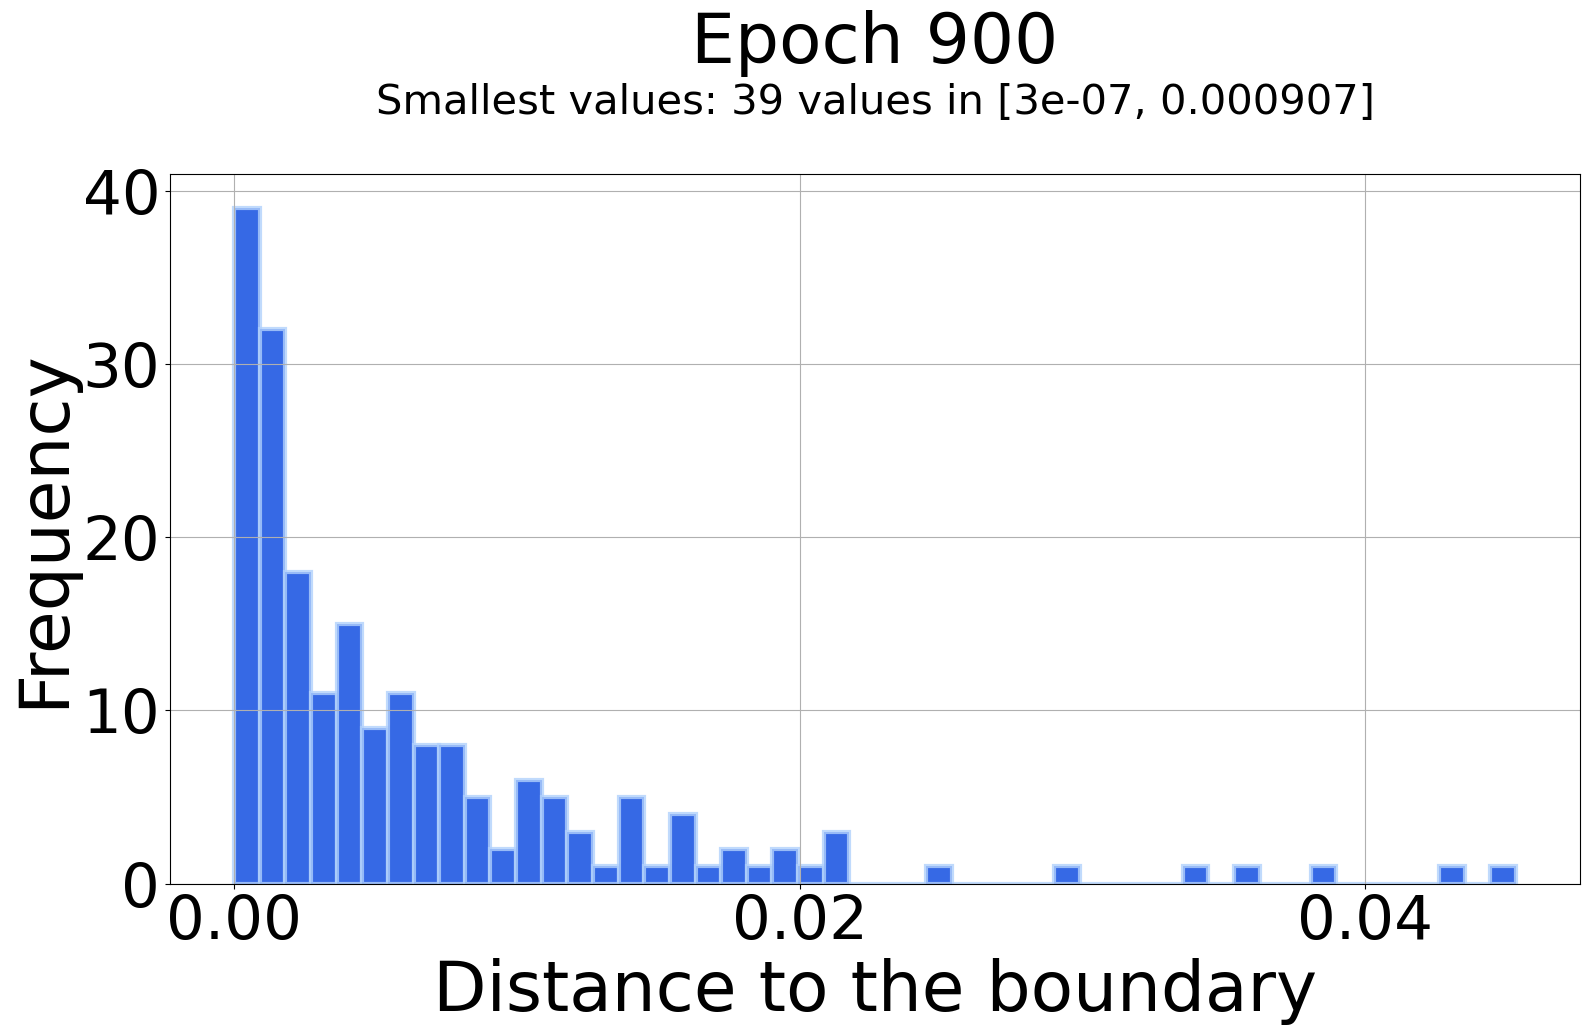

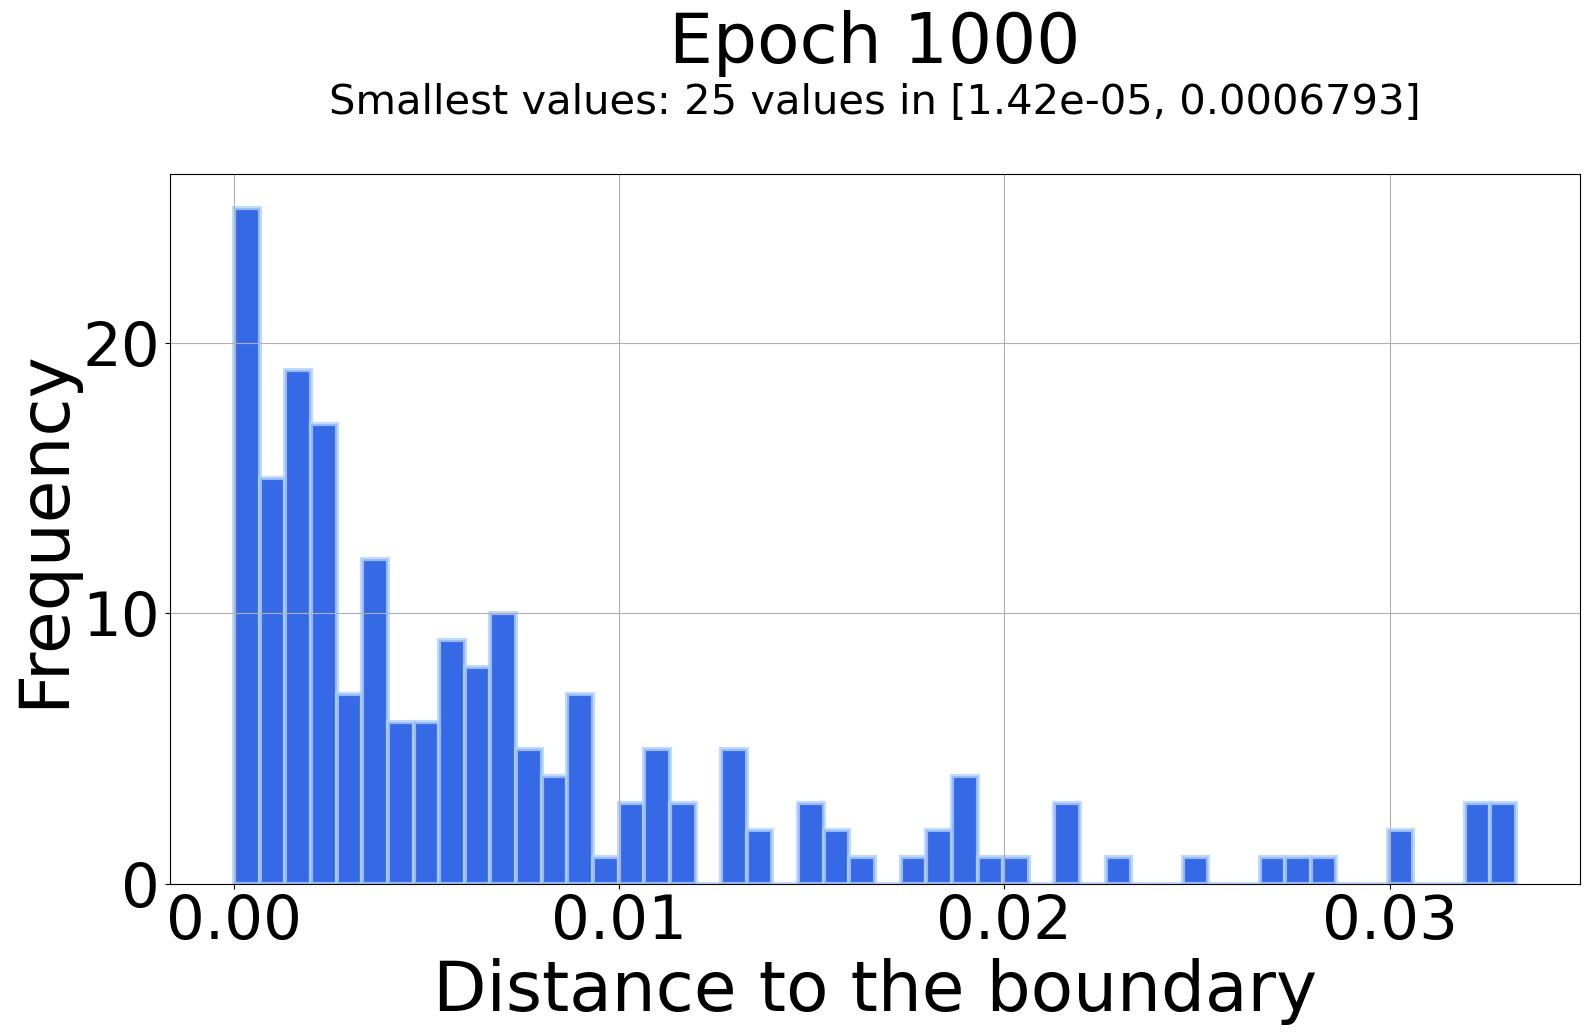

In [5]:
def plot_metric(x, y, y_std, ylabel, log, timestamp):
    fig = plt.figure(figsize=(16, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    if log:
        ax.set_yscale('log')
    
    plt.plot(x, y, linewidth=4, color='xkcd:blue', label=ylabel)
    plt.fill_between(x, y - y_std, y + y_std, facecolor='xkcd:blue', alpha=0.1)

    plt.xlabel('Epoch', size=50)
    plt.xlim(xmin=x[0], xmax=x[-1])
    ax.yaxis.get_offset_text().set_fontsize(30)
    if ylabel == 'Jacobian rank':
        plt.ylim(ymin=int(np.floor(np.min(y))) - 1, ymax=int(np.ceil(np.max(y))) + 1)

    if ylabel == 'Distance to the closest boundary':
        xticks = [0] + [i * 10 for i in range(1, len(x))]
        ax.set_xticks(x, xticks)
        plt.ylabel('Distance', size=50)
    else:
        plt.ylabel(ylabel, size=50)

    plt.legend(loc='upper left', fontsize=38, title_fontsize=42)
    plt.tight_layout()
    
    plt.savefig(f'images/jacobian_and_linear_regions/{timestamp}_{ylabel}.png')

def plot_histogram(x, epoch, timestamp):
    bins = 50
    
    fig = plt.figure(figsize=(16, 11), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    plt.title(f'Epoch {epoch}', fontsize=50, pad=80)
    hist, bins = np.histogram(x, bins=bins)
    plt.suptitle(f'Smallest values: {hist[0]} values in [{round(bins[0], 7)}, {round(bins[1], 7)}]',
                 fontsize=30, y=.87, x=.55)
    
    plt.hist(x, bins=bins, facecolor='xkcd:blue', edgecolor='xkcd:powder blue', linewidth=3, alpha=0.8)
    plt.xlabel('Distance to the boundary', size=50)
    plt.ylabel('Frequency', size=50)
    plt.locator_params(axis='x', nbins=4)
    
    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f'images/jacobian_and_linear_regions/{timestamp}_distance_to_boundary_epoch{epoch}.png')
    
# #######################################################################################################
# #######################################################################################################

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# ################################################
# # Generate the plots
# ################################################

loss_mean = np.mean(total_loss, axis=0)
loss_std = np.std(total_loss, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=loss_mean, y_std=loss_std, ylabel='Loss', log=True,
           timestamp=timestamp)

# rank_mean = np.mean(total_ranks, axis=0)
# rank_std = np.std(total_ranks, axis=0)
# plot_metric(x=list(range(EPOCHS_NUM + 1)), y=rank_mean, y_std=rank_std, ylabel='Jacobian rank',
#             log=False, timestamp=timestamp)

ratio_mean = np.mean(total_ratios, axis=0)
ratio_std = np.std(total_ratios, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=ratio_mean, y_std=ratio_std,
            ylabel='Singular values ratio', log=False, timestamp=timestamp)

a_rank_mean = np.mean(total_a_ranks, axis=0)
a_rank_std = np.std(total_a_ranks, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=a_rank_mean, y_std=a_rank_std,
            ylabel='Rank of matrix $A$', log=False, timestamp=timestamp)

# The last pattern_arr is plotted
tp_arr = [tuple(pattern.reshape(-1)) for pattern in pattern_arr]
pattern_dict = {}
for tp in tp_arr:
    if tp not in pattern_dict:
        pattern_dict[tp] = len(pattern_dict)
pattern_id_arr = np.asarray([pattern_dict[tp] for tp in tp_arr])
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=pattern_id_arr, y_std=np.zeros(EPOCHS_NUM + 1),
            ylabel='Activation pattern id', log=False, timestamp=timestamp)

# Distance to the boundary
for e_id, da in enumerate(distance_arr):
    plot_histogram(x=da, epoch=e_id * DISTANCE_EPOCH, timestamp=timestamp)
    
################################################
# Store data for the later reference
################################################
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_loss.txt', total_loss)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_rank.txt', total_ranks)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_ratio.txt', total_ratios)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_a_rank.txt', a_rank_arr)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_pattern_id.txt', pattern_id_arr)
np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_distance_to_boundary.txt', distance_arr)